# EV Charging Station Utilization & Demand Patterns

### Project Description
The goal of this project is to analyze EV charging station data, which contains detailed information about station locations, charging capacities, availability, usage statistics, and more. We will uncover utilization and demand patterns by exploring how factors like charging capacity, availability hours, and installation year influence station usage. This analysis will provide data-driven insights to optimize EV charging infrastructure, enhance user accessibility, and improve resource allocation.

### Key Findings

**EV Insights**
- Steady and Sustainable Growth: Focus on long-term expansion with a balanced approach.
- Moderate Number of Installations: Avoid oversaturation while ensuring accessibility.
- Limited Operating Hours: Optimize resource allocation and reduce costs.
- Use 50 or 150 kW Chargers: Cost-effective solution without sacrificing functionality.
- Plan for Growth Strategically:
- Expand in moderate-use cities to establish presence.
- Add more chargers in high-demand cities to maximize impact.
- Leverage Government Subsidies: Invest in cities where subsidies lower installation and operational costs.

**Additional Notes**
- Dataset was too broad and compromised (ex. Latitude and Longitude were incorrect)
- Data evenly distributed across all questions and analysis

In [ ]:
# Dependencies Import Setup 
#---------------------------
import pandas as pd  
# Pandas is used for data manipulation and analysis, such as reading and working with CSV files.
from pathlib import Path
# The path class provides as easy and platform-independent way to work with file system paths.
import numpy as np
# NumPy is used for numerical operations and working with arrays, which is often helpful in data analysis.
import matplotlib.pyplot as plt
# Pyplot is used to create visualizations like plots and charts.
import requests
# The requests library is used to make HTTP requests, which can be useful for fetching data from web APIs.
import os
# The os module provides a way to interact with the operations system, such as reading enviroment variables or working with file paths

# Import time 
import time

# seaborn built on top of matplotlib can be easier to create complex statistical graphs, or more pleasing data visualizations
import seaborn as sns

# Import citipy to determine the cities based on latitude and longitude
from citipy import citipy

# Import folium
import folium

#Import HeatMap
from folium.plugins import HeatMap

import hvplot.pandas

import plotly.graph_objects as go

#Import geopandas 
import geopandas as gpd

# scipy import
from scipy.stats import linregress
from scipy.stats import pearsonr

%matplotlib inline
# This is a jupyter notebook magic command
# It tells the notebook to display Matplotlib plots directly within the notebook cells (inline) rather than in a seprarte window.




In [70]:
# 1. Data Cleaning & Preperation
# ------------------------------

file_path = Path("data/detailed_ev_charging_stations.csv")
# Creates a Path object that points to the CSV file.
# Using a Path object helps manage file paths in a way that's indepentent of the operating system.
# Be cautious with backslashes (\) as they can be interpreted as escape characters. You might consider using raw strings (e.g., r"\Repos\ev-charging-stations\data\
# detailed_ev_charging_station.csv") or forward slashes (/).

detailed_ev_charging_station = pd.read_csv(file_path)
# Reads the csv file located at file_path into a Pandas DataFrame called detailed_ev_charging_station.
# This allows you to work with the data (e.g., inspect, manipluate, analyze) using the tools provided by Pandas.

detailed_ev_charging_station.rename(columns={ 
    'Installation Year': 'Installation Year',
    'Charging Capacity (kW)': 'Charging Capacity (kW)',
    '24/7 Availability': 'Is_24_7',
    'Usage Stats (avg users/day)': 'Usage (avg users/day)'
}, inplace=True)
# detailed_ev_charging_station.rename(columns={...}, inplace=True): This line renames the columns of the DataFrame.
# inplace=True: This argument modifes the origianl DataFrame directly rather than creating a new DataFrame with renamed columns.

initial_count = detailed_ev_charging_station.shape[0]
# This line assigns the number of rows in the DataFrame to the variable initial_counts.
    # .shape[0]: The shape attribute returns a truple representing the demensionality of the DataFrame. The first element (index 0) of the truple represents 
    # the nuber of rows.
detailed_ev_charging_station.drop_duplicates(inplace=True)
# This line drops the duplicate rows from the DataFrame.
    # drop_duplicates(): This method removes duplicate rows from the DataFrame.
    # inplace=True: This argumnet modifes the origianl DataFrame directly rather than creating a new DataFrame without duplicates.
final_count = detailed_ev_charging_station.shape[0]
# This line assigns the number of rows in the DataFrame after dropping duplicates to the variable final_count.


print(detailed_ev_charging_station.head())
# Prints the first 5 rows ot the DataFrame
# The .head() method is a quick way to inspect the top of the DataFrame, which helps confirm that the data was read correctly and gives you a glimps of its structure. 

print(f"\nDropped {initial_count - final_count} duplicate rows.")
# This line prints the number of duplicate rows that are dropped.
    # This is an f-string, which allows for the inculsion of expressions inside curly braces{}. The expression initial_count - final_count calculates the 
    # number of duplicate rows dropped. The \n at the beginng of the strin adds a newline character for formatting purpose.
print("\n===Missing Values by Column ===")
print(detailed_ev_charging_station.isnull().sum())

detailed_ev_charging_station.dropna(subset=['Installation Year', 'Charging Capacity (kW)', 'Usage (avg users/day)'], inplace=True)
# This line drops rows in the DataFrame that have missing values in the specified columns.
# subset=: Specifies the columns to check for missing values.
# inplace=True: Modifes the origianl DataFrame directly rather than creating a new DataFrame without the rows containing missing values.

if 'Cost' in detailed_ev_charging_station.columns:
    # Checks if the 'Cost' column exsits in the DataFrame.
    detailed_ev_charging_station['Cost'].fillna(detailed_ev_charging_station['Cost'].median(), inplace=True)
    # This line fills missing values in the 'Cost' column with the median value of that column.
    # fillna: Uses the median value of the 'Cost' column to fill the missing values and modifies the DataFrame in place.

if 'City' in detailed_ev_charging_station.columns:
    # This line fills missing values of the 'City' column with the mode (most frequent value) of that column.
    detailed_ev_charging_station['City'].fillna(detailed_ev_charging_station['City'].mode()[0], inplace=True)
    # fillna: Uses the mode value of the 'City' column to fill the missing values and modifies the DataFrame in place.

detailed_ev_charging_station['Charging Capacity (kW)'] = pd.to_numeric(detailed_ev_charging_station['Charging Capacity (kW)'], errors= 'coerce')
# This line converts 'Charging Capacity (kW)' column to numeric format.
# pd.to_numeric: Converts the values to numeric format and coerces any invaild parsing to Nan (Not a Number)

detailed_ev_charging_station['Usage (avg users/day)'] = pd.to_numeric(detailed_ev_charging_station['Usage (avg users/day)'], errors= 'coerce')
# This line converts 'Usage' column to numeric format.
# pd.to_numeric: Converts the values to numeric format and coerces any invaild parsing to Nan (Not a Number)

numeric_cols = detailed_ev_charging_station.select_dtypes(include=[np.number]).columns
for col in numeric_cols:
    # Thsi line selects all columns in the DataFrame that are of numeric type.
    # select-dtypes: Selects the numeric data types.
    # .columns: Returns the column names of the selected numeric columns.

    mean_val = detailed_ev_charging_station[col].mean()
    # Claculates the mean value of the current column.
    std_val = detailed_ev_charging_station[col].std()
    # Calculates the standard devation of the current column.
    cutoff = 3 * std_val
    # Defines the cutoff value for the outliers as three times the standard devation.
    lower, upper = mean_val - cutoff, mean_val + cutoff
    # Defines the lower and upper bonds for acceptable values (mean ± 3*std).
    detailed_ev_charging_station = detailed_ev_charging_station[(detailed_ev_charging_station[col] >= lower) & (detailed_ev_charging_station[col]<= upper)]
    # filters the DataFrame to keep only the rows where the values in the current column are within the acceptable range (between the upper and lower bonds).

print("n\=== Cleaned DataFrame Info ===")
# Prints a heading the the DataFrame information output.
# \n: Adds a newline character for formatting purposes.
detailed_ev_charging_station.info()
# Prints a summary of the Dataframe, including the number of rows, columns, and data types of each column.
print("\n=== first 5 Rows After Cleaning")
# Prints a heading for the first 5 rows of the DataFrame.
# \n: Adds a newline character for formatting purposes.
detailed_ev_charging_station.head()
# Prints the first 5 rows of the cleaned Dataframe.


  Station ID   Latitude   Longitude                                Address  \
0   EVS00001 -33.400998   77.974972       4826 Random Rd, City 98, Country   
1   EVS00002  37.861857 -122.490299  8970 San Francisco Ave, San Francisco   
2   EVS00003  13.776092  100.412776              5974 Bangkok Ave, Bangkok   
3   EVS00004  43.628250  -79.468935              6995 Toronto Ave, Toronto   
4   EVS00005  19.119865   72.913368                5704 Mumbai Ave, Mumbai   

      Charger Type  Cost (USD/kWh) Availability  Distance to City (km)  \
0       AC Level 2            0.27   9:00-18:00                   4.95   
1  DC Fast Charger            0.19         24/7                   4.96   
2       AC Level 2            0.48   6:00-22:00                   8.54   
3       AC Level 1            0.41   9:00-18:00                  13.28   
4       AC Level 2            0.11   9:00-18:00                   9.76   

   Usage (avg users/day) Station Operator  Charging Capacity (kW)  \
0                

,Station ID,Latitude,Longitude,Address,Charger Type,Cost (USD/kWh),Availability,Distance to City (km),Usage (avg users/day),Station Operator,Charging Capacity (kW),Connector Types,Installation Year,Renewable Energy Source,Reviews (Rating),Parking Spots,Maintenance Frequency
0,EVS00001,-33.400998,77.974972,"4826 Random Rd, City 98, Country",AC Level 2,0.27,9:00-18:00,4.95,35,EVgo,350,"CCS, CHAdeMO",2013,Yes,4.0,7,Annually
1,EVS00002,37.861857,-122.490299,"8970 San Francisco Ave, San Francisco",DC Fast Charger,0.19,24/7,4.96,83,EVgo,350,"Tesla, Type 2",2010,Yes,3.9,2,Monthly
2,EVS00003,13.776092,100.412776,"5974 Bangkok Ave, Bangkok",AC Level 2,0.48,6:00-22:00,8.54,24,ChargePoint,50,"Type 2, CCS",2019,No,3.6,9,Annually
3,EVS00004,43.628250,-79.468935,"6995 Toronto Ave, Toronto",AC Level 1,0.41,9:00-18:00,13.28,70,Greenlots,350,Type 2,2010,Yes,4.2,7,Monthly
4,EVS00005,19.119865,72.913368,"5704 Mumbai Ave, Mumbai",AC Level 2,0.11,9:00-18:00,9.76,19,EVgo,350,CCS,2015,Yes,3.7,6,Annually


In [71]:
# Remove rows where 'address' contains a partial string (e.g., 'Random Rd')
detailed_ev_charging_station_cleaned = detailed_ev_charging_station[~detailed_ev_charging_station['Address'].str.contains('Random Rd', na=False)].copy()

# Display the updated DataFrame
detailed_ev_charging_station_cleaned.head()

,Station ID,Latitude,Longitude,Address,Charger Type,Cost (USD/kWh),Availability,Distance to City (km),Usage (avg users/day),Station Operator,Charging Capacity (kW),Connector Types,Installation Year,Renewable Energy Source,Reviews (Rating),Parking Spots,Maintenance Frequency
1,EVS00002,37.861857,-122.490299,"8970 San Francisco Ave, San Francisco",DC Fast Charger,0.19,24/7,4.96,83,EVgo,350,"Tesla, Type 2",2010,Yes,3.9,2,Monthly
2,EVS00003,13.776092,100.412776,"5974 Bangkok Ave, Bangkok",AC Level 2,0.48,6:00-22:00,8.54,24,ChargePoint,50,"Type 2, CCS",2019,No,3.6,9,Annually
3,EVS00004,43.628250,-79.468935,"6995 Toronto Ave, Toronto",AC Level 1,0.41,9:00-18:00,13.28,70,Greenlots,350,Type 2,2010,Yes,4.2,7,Monthly
4,EVS00005,19.119865,72.913368,"5704 Mumbai Ave, Mumbai",AC Level 2,0.11,9:00-18:00,9.76,19,EVgo,350,CCS,2015,Yes,3.7,6,Annually
5,EVS00006,-23.695008,-46.548187,"1545 São Paulo Ave, São Paulo",AC Level 2,0.22,6:00-22:00,2.02,39,Ionity,350,Tesla,2016,Yes,3.2,9,Quarterly


In [72]:
detailed_ev_charging_station_cleaned[['Addresses', 'City']] = detailed_ev_charging_station_cleaned['Address'].str.split(', ', expand=True)

detailed_ev_charging_station_cleaned = detailed_ev_charging_station_cleaned.drop(columns=['Address'])
final_ev_data = detailed_ev_charging_station_cleaned.copy()
final_ev_data.head()

,Station ID,Latitude,Longitude,Charger Type,Cost (USD/kWh),Availability,Distance to City (km),Usage (avg users/day),Station Operator,Charging Capacity (kW),Connector Types,Installation Year,Renewable Energy Source,Reviews (Rating),Parking Spots,Maintenance Frequency,Addresses,City
1,EVS00002,37.861857,-122.490299,DC Fast Charger,0.19,24/7,4.96,83,EVgo,350,"Tesla, Type 2",2010,Yes,3.9,2,Monthly,8970 San Francisco Ave,San Francisco
2,EVS00003,13.776092,100.412776,AC Level 2,0.48,6:00-22:00,8.54,24,ChargePoint,50,"Type 2, CCS",2019,No,3.6,9,Annually,5974 Bangkok Ave,Bangkok
3,EVS00004,43.628250,-79.468935,AC Level 1,0.41,9:00-18:00,13.28,70,Greenlots,350,Type 2,2010,Yes,4.2,7,Monthly,6995 Toronto Ave,Toronto
4,EVS00005,19.119865,72.913368,AC Level 2,0.11,9:00-18:00,9.76,19,EVgo,350,CCS,2015,Yes,3.7,6,Annually,5704 Mumbai Ave,Mumbai
5,EVS00006,-23.695008,-46.548187,AC Level 2,0.22,6:00-22:00,2.02,39,Ionity,350,Tesla,2016,Yes,3.2,9,Quarterly,1545 São Paulo Ave,São Paulo


In [90]:
%%capture --no-display

# Configure the map plot
# Display the map

final_ev_data.hvplot.scatter(
    x='Longitude', y='Latitude', color='City', size=30, alpha=0.5, tiles='OSM',
     xlabel='Longitude', ylabel='Latitude', title = 'EV Charging Station Locations', width=900, height=400
)

:Overlay
   .Tiles.I   :Tiles   [x,y]
   .Scatter.I :Scatter   [x]   (y,City)

## 2.Trend in EV Installations Over the Years:

### Key Observations

- Steady growth with fluctuations showing installations generally increase, though some years experience slowdowns, and slight negative growth in installations.  
- It clearly shows there are a few market leaders in the growth rate distribution showing certain companies dominate, year over year growth even if they have a few years of negative growth.  
- There is a recent plateau in the most recent years for most station operators this could be due to several factors including potential market saturation or influence from tech advancements and regulatory changes.

### Potential Reasons
- Market saturation or policy shifts: Could cause fluctuations or slowdowns in installations.
- Regional vs. global strategies: Some operators could focus on local growth, while others pursue broader expansion.
- Technological advancements: New charging technology or infrastructure changes may impact installation rates.

### Recommendations

- Focus on steady expansion by building on consistent growth rather than aiming for rapid expansion.
- Look into flat growth years to understand why growth slowed and adjust future plans to avoid stagnation or negative growth
- Invest in areas with demand by focusing on regions that still need more stations to keep growth moving forward.


<Figure size 1400x700 with 0 Axes>

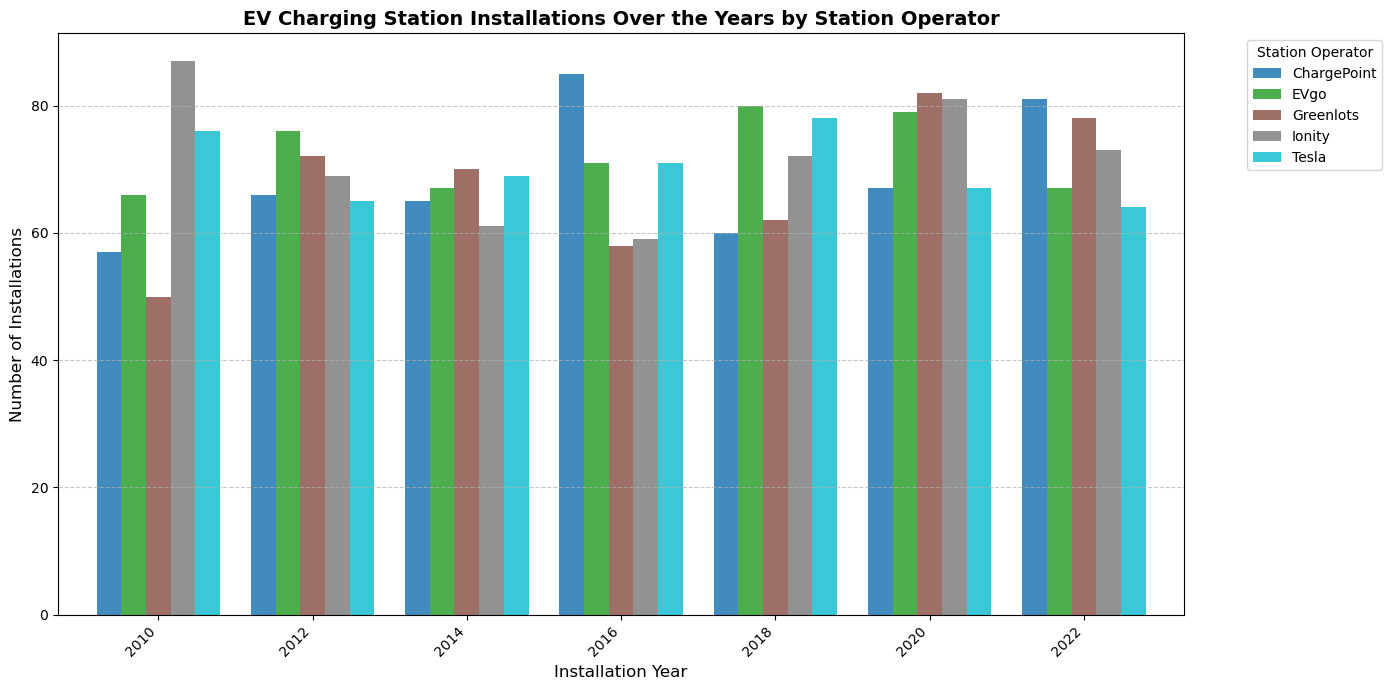

In [74]:
# 2.  Part 1: Trend in EV Installations Over the Years
# ----------------------------------------------------------------------------------------------------------------------------------

# Aggregate Installation Counts Per Year and Station Operator
installations_per_operator = detailed_ev_charging_station.groupby(['Installation Year', 'Station Operator']).size().unstack(fill_value=0)

# Filter to Keep Every Other Year
filtered_years = installations_per_operator.index[::2]  # Selects every other year
installations_per_operator = installations_per_operator.loc[filtered_years]

# Plot Grouped Bar Chart
plt.figure(figsize=(14, 7))
installations_per_operator.plot(kind='bar', colormap='tab10', alpha=0.85, width=0.8, figsize=(14, 7))

# Labels and Titles
plt.title('EV Charging Station Installations Over the Years by Station Operator', fontsize=14, fontweight='bold')
plt.xlabel('Installation Year', fontsize=12)
plt.ylabel('Number of Installations', fontsize=12)
plt.xticks(rotation=45, ha='right', fontsize=10)  # Rotate x-axis labels for readability
plt.yticks(fontsize=10)
plt.grid(axis='y', linestyle='--', alpha=0.7)  # Add a horizontal grid for clarity

# Legend & Layout Adjustments
plt.legend(title='Station Operator', bbox_to_anchor=(1.05, 1), loc='upper left', fontsize=10)
plt.tight_layout()

# Show the Chart
plt.show()




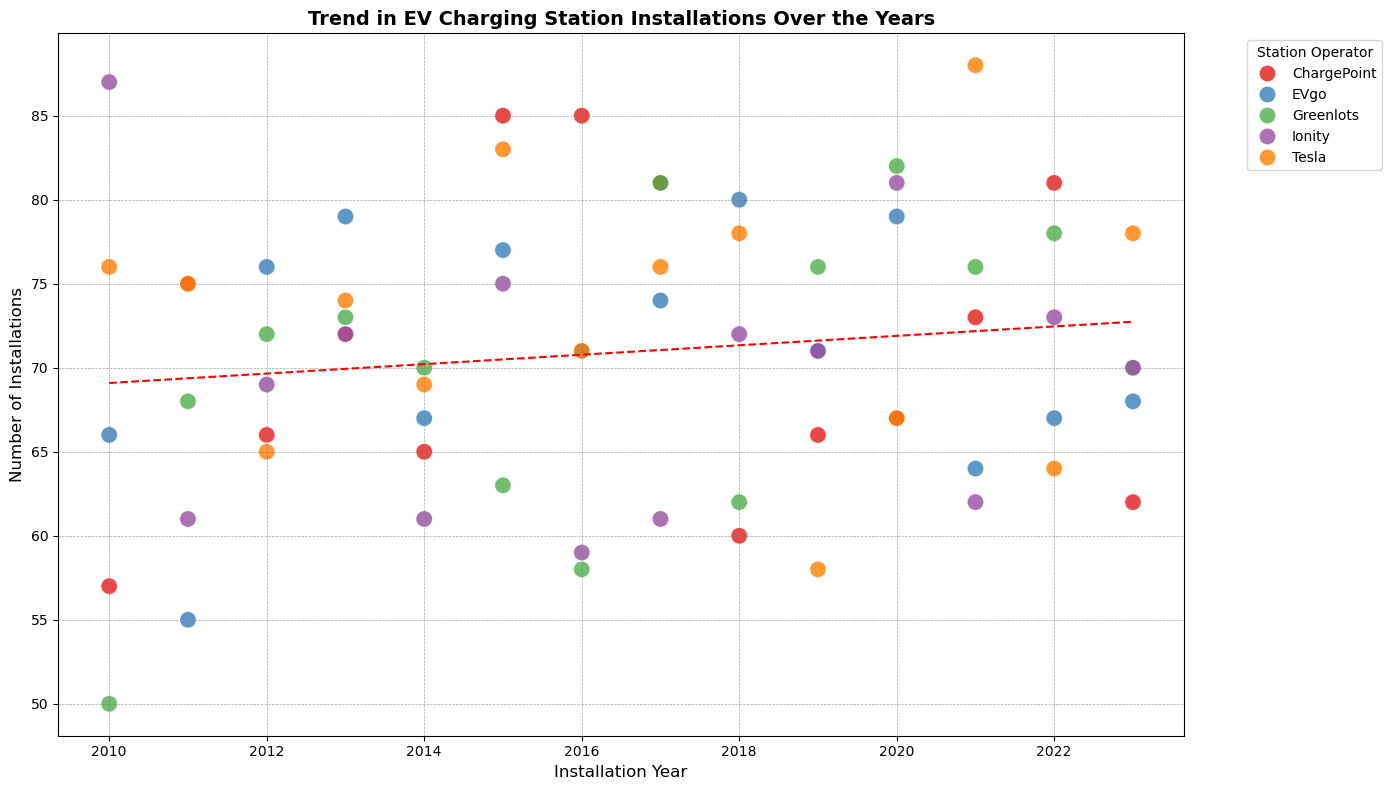

Pearson Correlation Coefficient: 0.14
R-squared Value: 0.02
P-value: 0.2517
count    70.000000
mean     70.914286
std       8.201702
min      50.000000
25%      65.250000
50%      71.000000
75%      76.000000
max      88.000000
Name: Installations, dtype: float64


In [75]:
# 2.  Part 2: Trend in EV Installations Over the Years
# ----------------------------------------------------------------------------------------------------------------------------------

# Create a New DataFrame with Relevant Columns
ev_installations = detailed_ev_charging_station[['Installation Year', 'Station Operator']].copy()

# Group Data by Installation Year and Station Operator
installations_per_year = ev_installations.groupby(['Installation Year', 'Station Operator']).size().reset_index(name='Installations')

# Regression Analysis
slope, intercept, r_value, p_value, std_err = linregress(installations_per_year['Installation Year'], installations_per_year['Installations'])

# Visualization: Scatter Plot with Regression Line
plt.figure(figsize=(14, 8))
sns.scatterplot(
    x='Installation Year', 
    y='Installations', 
    data=installations_per_year, 
    hue='Station Operator',            # Color based on Station Operator
    palette='Set1',                    # Color palette set
    s=150,                             # Marker size
    alpha=0.8,                         # Slight transparency
    legend='full'                      # Show full legend
)

# Add Regression Line
plt.plot(installations_per_year['Installation Year'], intercept + slope * installations_per_year['Installation Year'], color='red', linestyle='--')

# Plot Styling
plt.title('Trend in EV Charging Station Installations Over the Years', fontsize=14, fontweight='bold')
plt.xlabel('Installation Year', fontsize=12)
plt.ylabel('Number of Installations', fontsize=12)
plt.grid(color='gray', linestyle='--', linewidth=0.5, alpha=0.7)

# Adjust Legend Placement
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left', title='Station Operator')

# Display the Plot
plt.tight_layout()
plt.show()

# Key Metrics Print Out
#----------------------
# Corelation Coefficient (Pearson's r) - measures the stength and direction of the linear relationship between two variables 
correlation = installations_per_year['Installation Year'].corr(installations_per_year['Installations'])
print(f"Pearson Correlation Coefficient: {correlation:.2f}")

# R - squared value 
print(f"R-squared Value: {r_value**2:.2f}")

# P- value
print(f"P-value: {p_value:.4f}")

# Shows summary of key data charectoristics like mean, median, variance, etc
print(installations_per_year['Installations'].describe())


# Calculate Year-over-Year (YoY) Growth Rate
installations_per_year['YoY Growth (%)'] = installations_per_year.groupby('Station Operator')['Installations'].pct_change() * 100

# Fix first-year growth rates by replacing NaN values with 0%
installations_per_year['YoY Growth (%)'] = installations_per_year['YoY Growth (%)'].fillna(0)





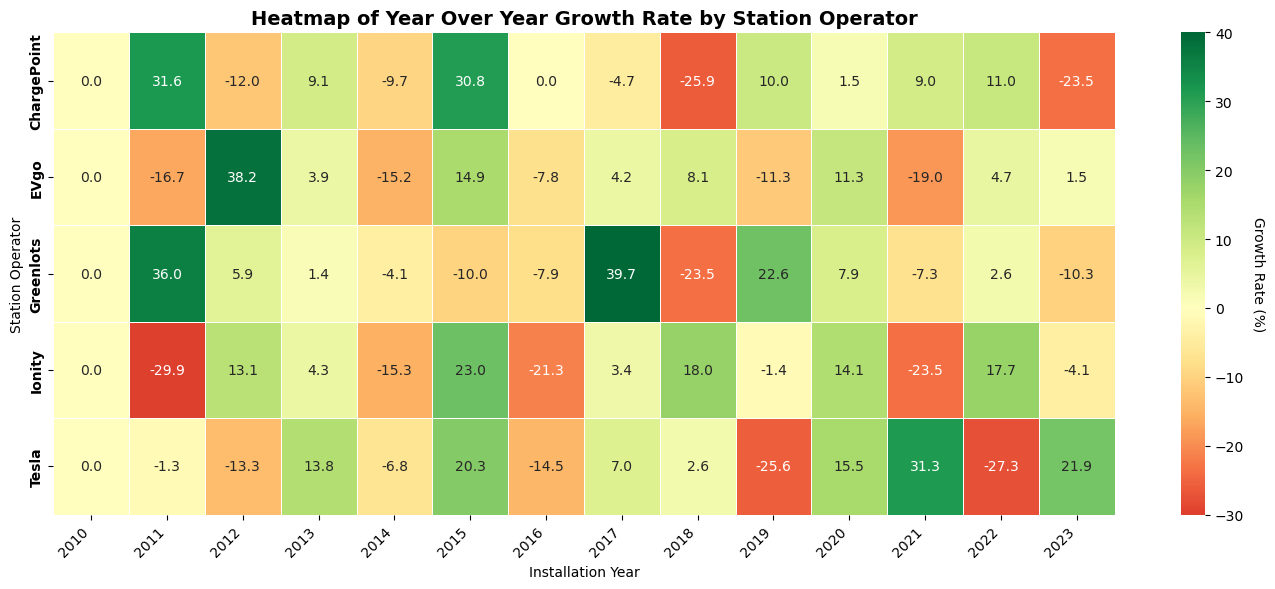

In [76]:
# 2.  Part 3: EV Instalations Year of Year Growth Rate
# ----------------------------------------------------------------------------------------------------------------------------------

# Data for Heatmap
installations_per_year['Installation Year'] = installations_per_year['Installation Year'].astype(int)
heatmap_data = installations_per_year.pivot(index='Station Operator', columns='Installation Year', values='YoY Growth (%)')

# Sort the years for proper display
heatmap_data = heatmap_data.reindex(sorted(heatmap_data.columns), axis=1)

# Fill missing values for consistent display
heatmap_data = heatmap_data.fillna(0)

# Heatmap Visualization
plt.figure(figsize=(14, 6))
heatmap = sns.heatmap(
    heatmap_data, 
    cmap='RdYlGn',                 # Green for positive growth, Red for negative
    annot=True,                      # Annotate cells with data
    fmt=".1f",                       # Format annotations
    linewidths=0.5,                  # Grid lines
    center=0,                        # Center around zero
    vmin=-30, vmax=40,               # Standardized color scaling
    annot_kws={"size": 10}          # Annotation size
)

# Plot Styling
plt.title('Heatmap of Year Over Year Growth Rate by Station Operator', fontsize=14, fontweight='bold')
plt.xlabel('Installation Year')
plt.ylabel('Station Operator')
plt.xticks(rotation=45, ha='right', fontsize=10)  # Rotate x-axis labels
plt.yticks(fontsize=10, fontweight='bold')        # Bold y-axis labels

# Add Color Bar Title
cbar = heatmap.collections[0].colorbar
cbar.set_label('Growth Rate (%)', rotation=270, labelpad=15)

plt.tight_layout()

# Display the Heatmap
plt.show()



/var/folders/77/g0ql5jbj0_3bh515zpj9kwv80000gn/T/ipykernel_53463/3864067854.py:9: FutureWarning:



Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.




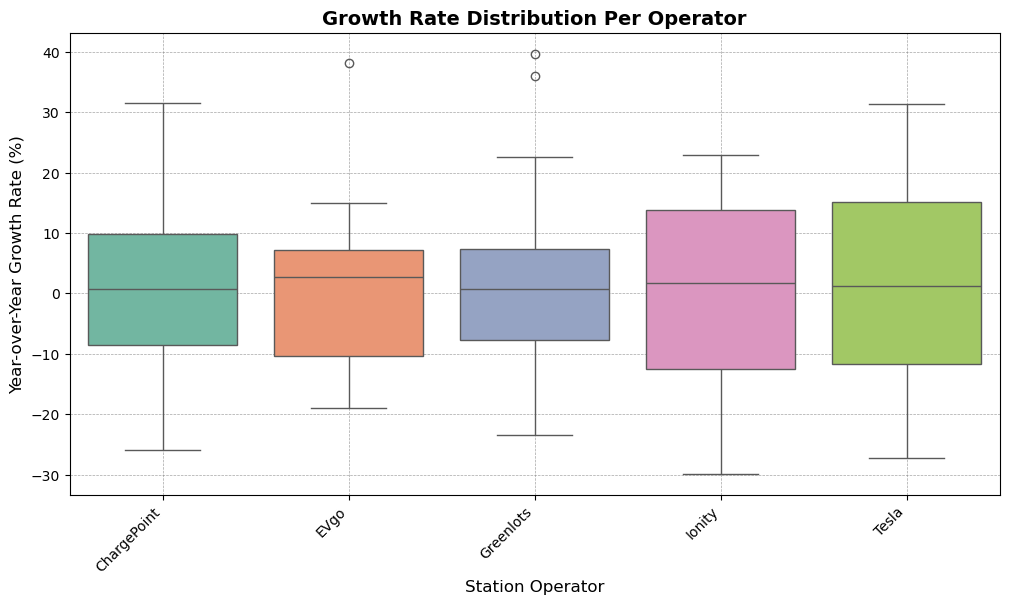

In [77]:
# 2.  Part 3: Box Plot: Growth Rate Year over Year Distribution Per Operator
# ----------------------------------------------------------------------------------------------------------------------------------

# Prepare Data for Box Plot
boxplot_data = installations_per_year[['Station Operator', 'YoY Growth (%)']].dropna()

# Create Box Plot
plt.figure(figsize=(12, 6))
sns.boxplot(
    x='Station Operator', 
    y='YoY Growth (%)', 
    data=boxplot_data, 
    palette='Set2'  # Adjust the color scheme
)

# Plot Styling
plt.title('Growth Rate Distribution Per Operator', fontsize=14, fontweight='bold')
plt.xlabel('Station Operator', fontsize=12)
plt.ylabel('Year-over-Year Growth Rate (%)', fontsize=12)
plt.xticks(rotation=45, ha='right', fontsize=10)  # Rotate x-axis labels for better readability
plt.grid(color='gray', linestyle='--', linewidth=0.5, alpha=0.7)

# Show Plot
plt.show()



### Key Findings

- Overall, there is not a huge difference between the total daily users and the charging capacity of an EV charging station. The stations with 50kW and 150kW charging capacity have higher usage than those with 22kW AND 350kW charging capacity.

### Potential Reasons

- Certain vehicles may not be able to utilize the full capacity of a 350kW charger.
- There may be more 50kW and 150kW chargers in higher-traffic areas.

### Recommendation

- Focusing on 50kW and 150kW chargers in and around major cities has the best return on investment. These stations cater to the majority of EV drivers. These charging speeds meet the needs of drivers as well as keep infrastructure costs lower.


In [98]:
# 3.  Charging Capacity vs. Station Usage

# Create new data frame with selected columns 
capacity_df = final_ev_data[[
    'Station ID', 'Latitude', 'Longitude', 'Usage (avg users/day)', 
    'Charger Type', 'Charging Capacity (kW)', 'Cost (USD/kWh)', 'City', 'Distance to City (km)'
]].copy()

capacity_df.head()

,Station ID,Latitude,Longitude,Usage (avg users/day),Charger Type,Charging Capacity (kW),Cost (USD/kWh),City,Distance to City (km)
1,EVS00002,37.861857,-122.490299,83,DC Fast Charger,350,0.19,San Francisco,4.96
2,EVS00003,13.776092,100.412776,24,AC Level 2,50,0.48,Bangkok,8.54
3,EVS00004,43.628250,-79.468935,70,AC Level 1,350,0.41,Toronto,13.28
4,EVS00005,19.119865,72.913368,19,AC Level 2,350,0.11,Mumbai,9.76
5,EVS00006,-23.695008,-46.548187,39,AC Level 2,350,0.22,São Paulo,2.02


In [99]:
# 3. 
charging_unique = capacity_df['Charging Capacity (kW)'].unique()
charging_unique

array([350,  50, 150,  22])

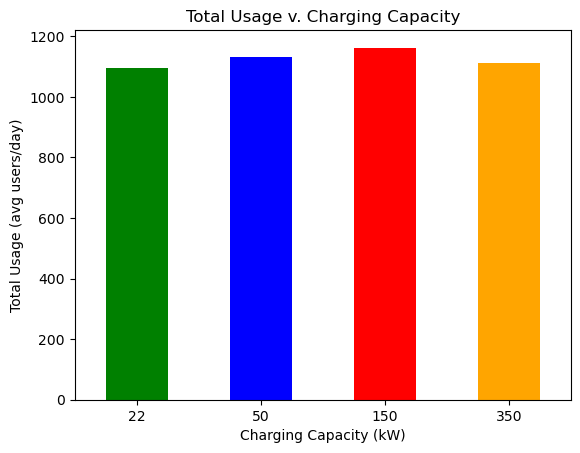

In [100]:
# 3. 
# Group by the capacity range and calculate the mean usage
grouped_data = capacity_df.groupby('Charging Capacity (kW)')['Usage (avg users/day)'].count()

# Plot the grouped data
grouped_data.plot(kind='bar', color=['green', 'blue', 'red', 'orange'])
plt.xlabel('Charging Capacity (kW)')
plt.ylabel('Total Usage (avg users/day)')
plt.title('Total Usage v. Charging Capacity')
plt.xticks(rotation=0)
plt.show()

## 4. Impact of 24/7 Availability on Usage

### Key Observations

- 24/7 availability does not appear to have a significant impact on the number of daily users.
- Access of 24/7 availability may not be a primary factor driving station usage.

### Potential Reasons

- Variables such as location, charger type, or cost might have a stronger influence.

### Recommendations

- Opening 24/7 stations may not be in an owner's best interest as there won't be significantly more usage than a limited hour station.


<Figure size 800x500 with 0 Axes>

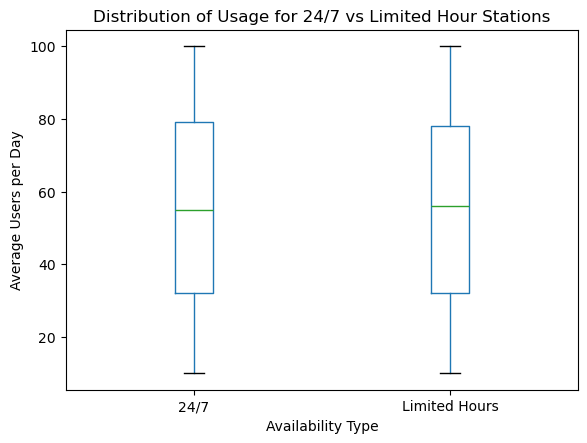

In [97]:
# 4.  Impact of 24/7 Availability on Usage
# Data Filtering, Statistical Comparison, and Box Plot Visualization to compare distribution
# ------------------------------------------------------------------------------------------

# Filter Data 
usage_availability = detailed_ev_charging_station[['Station ID', 'Latitude', 'Longitude', 'Address', 'Availability', 'Usage (avg users/day)']].copy()

# Compare Usage between 24/7 stations and limiited hour stations
# Calculate Average Daily Usage for both Categories 

usage_availability['Availability Type'] = usage_availability['Availability'].apply(lambda x: '24/7' if x == '24/7' else 'Limited Hours')
usage_comparison = usage_availability.groupby('Availability Type')['Usage (avg users/day)'].mean()

# Build 1-2 data visualization using Box Plot and or Bar Charts 
# Create a box plot showing all data points for 24/7 and limited availability
plt.figure(figsize=(8, 5))
usage_availability.boxplot(column='Usage (avg users/day)', by='Availability Type', grid=False, showfliers=True)

# Remove default generated title
plt.suptitle("")

# Set plot labels and title
plt.xlabel("Availability Type")
plt.ylabel("Average Users per Day")
plt.title("Distribution of Usage for 24/7 vs Limited Hour Stations")

# Show the plot
plt.show()

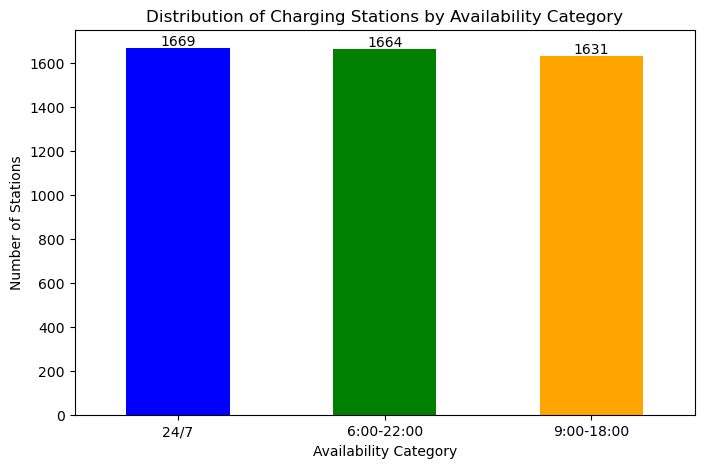

In [82]:
# Bin the data into categories based on the unique values in the Availability column.
# Define Binning
def usage_category_bins(time):
    if time == "24/7":
        return "24/7"
    elif time == "6:00-22:00":
        return "6:00-22:00"
    elif time == "9:00-18:00":
        return "9:00-18:00"
    else:
        return "Other"

#Apply Binning
usage_availability['Availability Categories'] = usage_availability['Availability'].apply(usage_category_bins)

#Count the number of stations in each bin
availability_categories = usage_availability['Availability Categories'].value_counts()

# Plot the distribution
plt.figure(figsize=(8, 5))
ax = availability_categories.plot(kind='bar', color=['blue', 'green', 'orange', 'red'])

# Add data labels on top of each bar
for p in ax.patches:
    ax.annotate(f"{p.get_height()}", 
                (p.get_x() + p.get_width() / 2, p.get_height()), 
                ha='center', va='bottom')

# Set labels and title
plt.xlabel("Availability Category")
plt.ylabel("Number of Stations")
plt.title("Distribution of Charging Stations by Availability Category")
plt.xticks(rotation=0)

# Show the plot
plt.show()

## City-Wise Charging Station Usage

- High Usage: San Francisco, Mumbai, Toronto, Beijing, Moscow, and Cape Town have a lot of people using charging stations every day.
- Low Usage: São Paulo has the least number of people using charging stations.
- Middle Usage: Cities like Berlin, Mexico City, Dubai, Sydney, and Seoul are in  the middle in terms of usage.

### Key Takeaways

- Invest More: Add more charging stations in cities like San Francisco and Toronto where a higher number of people use them more.
- Understand Demand: Find out why some cities have high or low habits and needs.
- Raise Awareness: Teach the people in cities with low usage about the benefits of using charging stations.
- Plan for Growth: Be ready to expand in cities with moderate usage as more people start using electric vehicles.

City with Highest Utilization: San Francisco (57.85 users/day)
City with Lowest Utilization: São Paulo (52.31 users/day)


/var/folders/77/g0ql5jbj0_3bh515zpj9kwv80000gn/T/ipykernel_53463/423285512.py:12: FutureWarning:



Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.




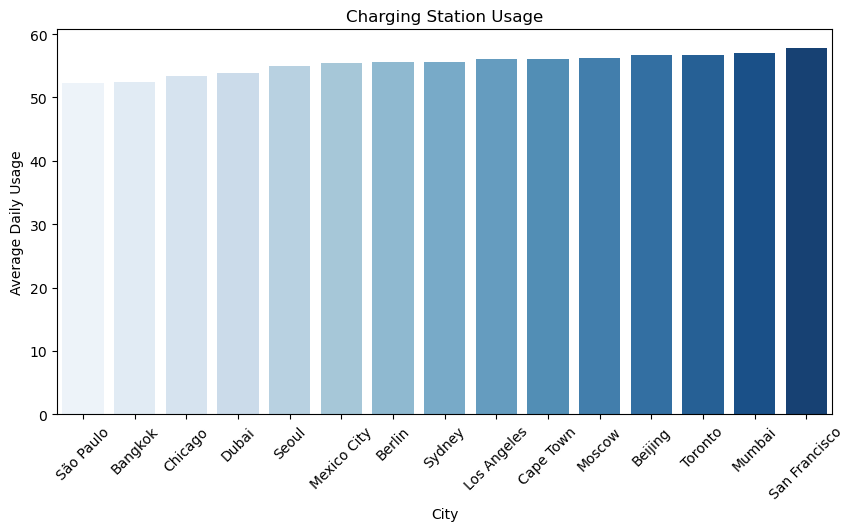

In [91]:
# 5.
city_usage = final_ev_data.groupby("City")["Usage (avg users/day)"].mean().reset_index()

city_usage = city_usage.sort_values(by='Usage (avg users/day)',ascending=True)

highest_us_city = city_usage.loc[city_usage["Usage (avg users/day)"].idxmax()]
lowest_us_city = city_usage.loc[city_usage["Usage (avg users/day)"].idxmin()]
print(f"City with Highest Utilization: {highest_us_city['City']} ({highest_us_city['Usage (avg users/day)']:.2f} users/day)")
print(f"City with Lowest Utilization: {lowest_us_city['City']} ({lowest_us_city['Usage (avg users/day)']:.2f} users/day)")

plt.figure(figsize=(10, 5))
sns.barplot(x=city_usage["City"], y=city_usage["Usage (avg users/day)"],palette='Blues')
plt.xticks(rotation=45)
plt.xlabel("City")
plt.ylabel("Average Daily Usage")
plt.title("Charging Station Usage")
plt.show()

In [84]:
# 5. 
distance_df = final_ev_data[['Distance to City (km)','Usage (avg users/day)', 'City']]
distance_df.head()


,Distance to City (km),Usage (avg users/day),City
1,4.96,83,San Francisco
2,8.54,24,Bangkok
3,13.28,70,Toronto
4,9.76,19,Mumbai
5,2.02,39,São Paulo


## Charging Station Usage in Cities Based on Distance from City Center.

### Data

- The scatter plot shows the usage of charging stations based on their distance from the city center.
    - Each blue dot represents a data point, indicating the average number of users per day at different distances.

### Regression Line

- The regression line is showing us that overall the distance within 20km does not have a huge impact on the daily usage in most of the cities shown here.

### High Usage Areas

- San Francisco:
    - The data points are widely scattered, indicating variability in charging station usage at distance.
    - The regression line has a slight positive slope, meaning that, on average, charging station usage slightly increases with distance from the city center.
    - This suggests that factors other than distance, such as location (residential vs. commercial), accessibility, or station capacity, influence usage.

### Lower Usage Areas

- Chicago:
    - The data appears widely scattered, meaning there is a significant variability in charging station usage.
    - The slope of the regression line is slightly negative, suggesting a week decreasing trend in usage as the distance from the city increases.
    - While there is some decrease in usage with increasing distance, the spread of the points show that charging stations at similar distances can have widely different usage.

### In Comparison

- San Francisco shows a higher increasing trend in usage as the distance increases, whereas Chicago has a week decreasing trend.
- Both cities exhibit high variability, meaning distance alone is not a strong predictor of usage.


In [92]:

# 5.
# Create an empty Plotly figure
fig = go.Figure()

# Add traces for each city
for city in distance_df['City'].unique():
    city_data = distance_df[distance_df['City'] == city]
    
    # Scatter plot for the city
    fig.add_trace(go.Scatter(x=city_data['Distance to City (km)'], 
                             y=city_data['Usage (avg users/day)'],
                             mode='markers', name=f'{city} (Data)'))
    
    # Calculate the regression line for the city using linregress
    slope, intercept, _, _, _ = linregress(city_data['Distance to City (km)'], 
                                           city_data['Usage (avg users/day)'])
    
    # Create the regression line
    regression_line_x = np.linspace(city_data['Distance to City (km)'].min(),
                                    city_data['Distance to City (km)'].max(),
                                    100)
    regression_line_y = slope * regression_line_x + intercept
    
    # Plot the regression line
    fig.add_trace(go.Scatter(x=regression_line_x, 
                             y=regression_line_y, 
                             mode='lines', 
                             name=f'{city} (Regression Line)', 
                             line=dict(color='red', dash='dash')))

# Add dropdown menu to filter cities
buttons = []
for city in distance_df['City'].unique():
    visible_list = [trace.name == f'{city} (Data)' or trace.name == f'{city} (Regression Line)' for trace in fig.data]
    buttons.append({'label': city,
                    'method': 'update',
                    'args': [{'visible': visible_list},
                             {'title': f"City-Wise Charging Station Usage: {city}"}]})

fig.update_layout(
    updatemenus=[
        {
            'buttons': buttons,
            'direction': 'down',
            'showactive': True,
        }
    ],
    title="Charging Station Usage with Regression Line",
    xaxis_title = 'Distance to City (km)',
    yaxis_title = 'Usage (avg users/day)'
)

# Show the plot
fig.show()

#Scatter plot will show every point when first run. Please select a city from the drop-down list on the left


## 6.Charging Cost by City Analysis.

The cost of charging per kWh varies across different cities due to multiple factors, including electricity generation sources, government subsidies, infrastructure, and demand-supply dynamics. Below is a comparative analysis:

### Top 3 Most Expensive Cities

1. Seoul (0.314 USD/kWh)
2. Moscow (0.313 USD/kWh)
3. Bangkok (0.309 USD/kWh)

### Top 3 Least Expensive Cities

1. Los Angeles (0.289 USD/kWh)
2. São Paulo (0.290 USD/kWh)
3. Dubai (0.294 USD/kWh)

### Possible reasons 

- The Likelihood of government subsidies, lower electricity rates, or other factors like competition is makes the cost per kWh to vary significantly
- Bangkok has the highest cost and may possibly be because due to higher electricity tariffs, infrastructure costs or lower competition with other EV charging providers in the city.
- Dubai (Low Cost): Heavily subsidized energy prices keep the cost lower.

### Recommendations

- Cities with high costs (Seoul, Moscow) should invest more in solar, wind, and hydroelectric power to reduce dependency on fossil fuels.
- Incentives for green energy production should be expanded.
- Cities like Mumbai and Mexico City should upgrade their grids to reduce transmission losses and improve efficiency.
- Implement differential pricing to incentivize charging during non-peak hours, reducing strain on the grid and lowering costs.
- Companies can also invest in cities that subsidize electric vehicles as a way of minimizing costs.


In [86]:
# 6.  Cost Analysis by City
# Calculate Average Cost per kWh, Visualize with Pie Chart
# ----------------------------------------------------------

Cost_analysis_by_city = final_ev_data[['Station ID', 'Latitude', 'Longitude', 'Usage (avg users/day)', 
    'Charger Type', 'Charging Capacity (kW)', 'Cost (USD/kWh)', 'City', 'Distance to City (km)'
]].copy()
Cost_analysis_by_city.head()


,Station ID,Latitude,Longitude,Usage (avg users/day),Charger Type,Charging Capacity (kW),Cost (USD/kWh),City,Distance to City (km)
1,EVS00002,37.861857,-122.490299,83,DC Fast Charger,350,0.19,San Francisco,4.96
2,EVS00003,13.776092,100.412776,24,AC Level 2,50,0.48,Bangkok,8.54
3,EVS00004,43.628250,-79.468935,70,AC Level 1,350,0.41,Toronto,13.28
4,EVS00005,19.119865,72.913368,19,AC Level 2,350,0.11,Mumbai,9.76
5,EVS00006,-23.695008,-46.548187,39,AC Level 2,350,0.22,São Paulo,2.02


In [87]:
#6.Group Data by City 
# Calculate the average cost and distribution of costs.  

avg_cost_per_city = final_ev_data.groupby("City")["Cost (USD/kWh)"].mean()
avg_cost_per_city


City
Bangkok          0.309968
Beijing          0.306050
Berlin           0.304897
Cape Town        0.295605
Chicago          0.299610
Dubai            0.294054
Los Angeles      0.289650
Mexico City      0.293396
Moscow           0.313594
Mumbai           0.301905
San Francisco    0.295031
Seoul            0.314114
Sydney           0.306576
São Paulo        0.290609
Toronto          0.296070
Name: Cost (USD/kWh), dtype: float64

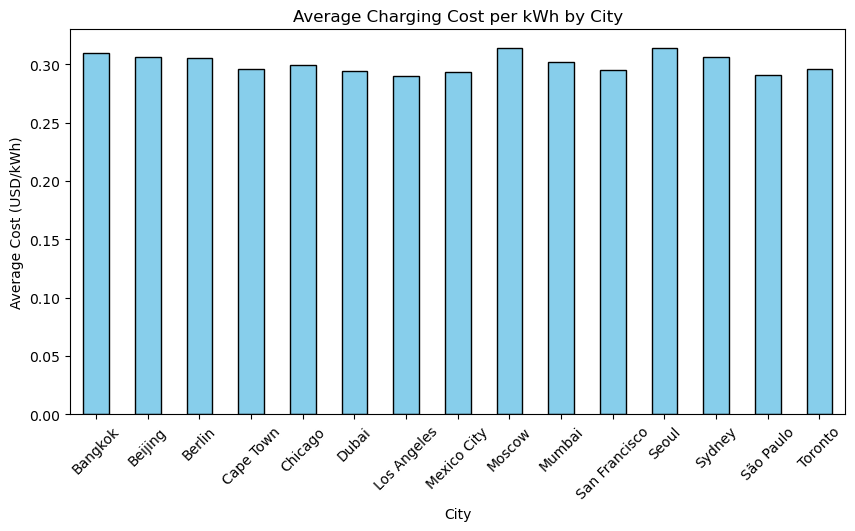

In [88]:
#6. bar Chart for cost distribution 

# Plot Bar Chart
plt.figure(figsize=(10, 5))
avg_cost_per_city.plot(kind="bar", color="skyblue", edgecolor="black")
plt.xlabel("City")
plt.ylabel("Average Cost (USD/kWh)")
plt.title("Average Charging Cost per kWh by City")
plt.xticks(rotation=45)

# Show Plot
plt.show()

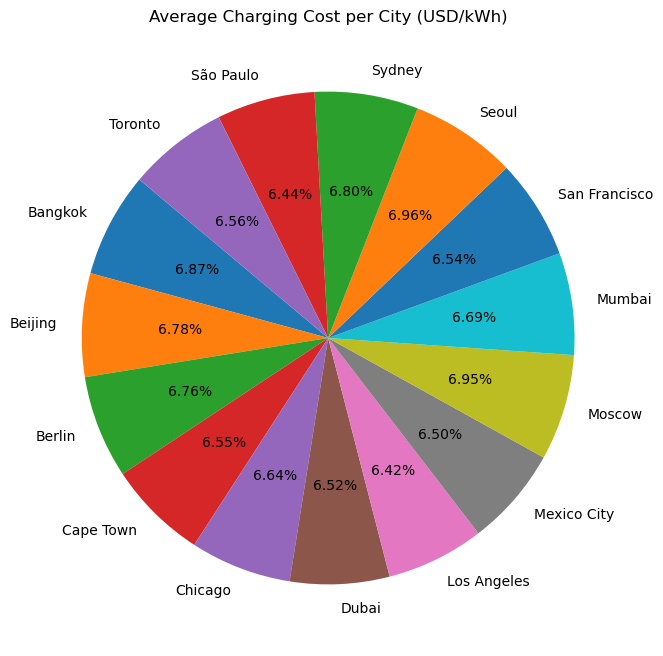

In [89]:
# 6.pie Chart for cost distribution 

# Plot pie chart
plt.figure(figsize=(8, 8))
plt.pie(avg_cost_per_city, labels=avg_cost_per_city.index,autopct='%1.2f%%',startangle=140)

plt.title("Average Charging Cost per City (USD/kWh)")
plt.show()
